ECE 9063 Data Analytics Project

In [357]:
!pip install -q -U keras-tuner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import kerastuner as kt

from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Set Random Seeds

In [358]:
np.random.seed(42)
tf.random.set_seed(42)

Importing Data

In [359]:
# ============== Importing data ======================
featureFile = 'combined_data.csv'
featureData = pd.read_csv(featureFile)

labelFile = 'SyedHouse-GreenButton-2018-07-01-2020-02-29.csv'
labelData = pd.read_csv(labelFile)

# put feature and label in one object
data = pd.concat([featureData, labelData['Usage (kilowatt-hours)']], axis=1)
data

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),Rel Hum Flag,Wind Dir (10s deg),Wind Dir Flag,Wind Spd (km/h),Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Usage (kilowatt-hours)
0,-81.15,43.03,LONDON A,6144473,2018-07-01 00:00,2018,7,1,00:00,25.0,NaN,20.9,NaN,78.0,NaN,21.0,NaN,10.0,NaN,24.1,NaN,98.35,NaN,33.0,NaN,NaN,NaN,NaN,3.53
1,-81.15,43.03,LONDON A,6144473,2018-07-01 01:00,2018,7,1,01:00,23.5,NaN,20.8,NaN,84.0,NaN,20.0,NaN,7.0,NaN,24.1,NaN,98.39,NaN,32.0,NaN,NaN,NaN,Clear,3.45
2,-81.15,43.03,LONDON A,6144473,2018-07-01 02:00,2018,7,1,02:00,22.9,NaN,20.6,NaN,86.0,NaN,19.0,NaN,5.0,NaN,24.1,NaN,98.39,NaN,31.0,NaN,NaN,NaN,NaN,3.36
3,-81.15,43.03,LONDON A,6144473,2018-07-01 03:00,2018,7,1,03:00,19.9,NaN,19.3,NaN,96.0,NaN,0.0,NaN,1.0,NaN,24.1,NaN,98.42,NaN,NaN,NaN,NaN,NaN,NaN,2.90
4,-81.15,43.03,LONDON A,6144473,2018-07-01 04:00,2018,7,1,04:00,20.1,NaN,19.6,NaN,97.0,NaN,26.0,NaN,5.0,NaN,24.1,NaN,98.38,NaN,27.0,NaN,NaN,NaN,Mainly Clear,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14611,-81.15,43.03,LONDON A,6144473,2020-02-29 19:00,2020,2,29,19:00,-6.7,NaN,-11.7,NaN,68.0,NaN,24.0,NaN,11.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-12.0,NaN,Mainly Clear,0.84
14612,-81.15,43.03,LONDON A,6144473,2020-02-29 20:00,2020,2,29,20:00,-7.0,NaN,-11.5,NaN,71.0,NaN,23.0,NaN,11.0,NaN,24.1,NaN,98.53,NaN,NaN,NaN,-12.0,NaN,NaN,0.88
14613,-81.15,43.03,LONDON A,6144473,2020-02-29 21:00,2020,2,29,21:00,-7.1,NaN,-11.2,NaN,73.0,NaN,20.0,NaN,9.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-11.0,NaN,NaN,0.98
14614,-81.15,43.03,LONDON A,6144473,2020-02-29 22:00,2020,2,29,22:00,-9.1,NaN,-12.0,NaN,80.0,NaN,20.0,NaN,8.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-13.0,NaN,Clear,0.93


<Figure size 720x360 with 0 Axes>

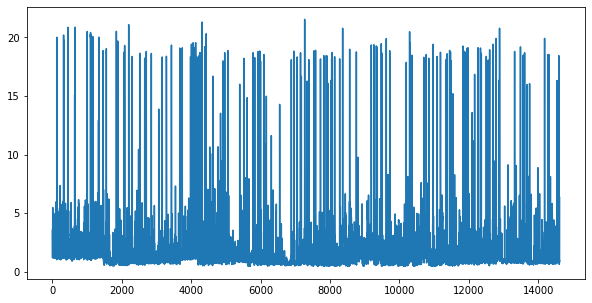

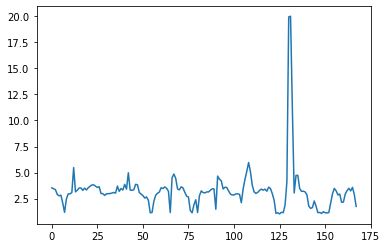

In [360]:
plt.figure(figsize=(10,5))
plt.plot(data['Usage (kilowatt-hours)'])
plt.show()

# close up on the first week
plt.plot(data['Usage (kilowatt-hours)'].head(168))
plt.show()

Data Cleaning

In [361]:
# ================= Data Cleaning =======================

# drop the columns with mostly missing values
data = data.drop(columns=["Temp Flag", "Dew Point Temp Flag", "Rel Hum Flag", "Wind Dir Flag", "Wind Spd Flag",
                   "Visibility Flag", "Stn Press Flag", "Hmdx", "Hmdx Flag", "Wind Chill", "Wind Chill Flag"])

# drop columns with constant data
data = data.drop(columns=["Longitude (x)", "Latitude (y)", "Station Name", "Climate ID", 'Date/Time'])

print(data.isnull().sum())

Year                         0
Month                        0
Day                          0
Time                         0
Temp (°C)                    9
Dew Point Temp (°C)          9
Rel Hum (%)                  9
Wind Dir (10s deg)          19
Wind Spd (km/h)              9
Visibility (km)              8
Stn Press (kPa)              9
Weather                   7211
Usage (kilowatt-hours)       0
dtype: int64


In [362]:
# Deal with missing values
columns_to_clean = ["Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Wind Dir (10s deg)", "Wind Spd (km/h)",
                    "Visibility (km)", "Stn Press (kPa)"]

# replace with previous hour data
for col in columns_to_clean:
    data[col].fillna(method='ffill', inplace=True)

print(data.isnull().sum())

Year                         0
Month                        0
Day                          0
Time                         0
Temp (°C)                    0
Dew Point Temp (°C)          0
Rel Hum (%)                  0
Wind Dir (10s deg)           0
Wind Spd (km/h)              0
Visibility (km)              0
Stn Press (kPa)              0
Weather                   7211
Usage (kilowatt-hours)       0
dtype: int64


Weather Attribute

In [363]:
# clean the "weather" attribute: replace missing values with previous observations
data["Weather"].fillna(method='ffill', inplace=True)

print(data.isnull().sum())

Year                      0
Month                     0
Day                       0
Time                      0
Temp (°C)                 0
Dew Point Temp (°C)       0
Rel Hum (%)               0
Wind Dir (10s deg)        0
Wind Spd (km/h)           0
Visibility (km)           0
Stn Press (kPa)           0
Weather                   1
Usage (kilowatt-hours)    0
dtype: int64


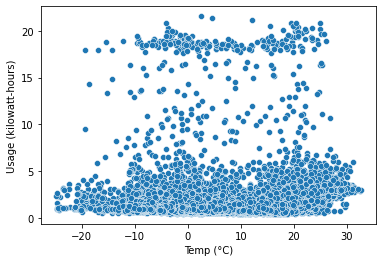

In [364]:
sns.scatterplot(data=data, x="Temp (°C)", y="Usage (kilowatt-hours)")

Feature Engineering

Hour of Day

In [365]:
data['Time'] = data['Time'].apply(lambda s: float(s.split(':')[0]))
data

,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather,Usage (kilowatt-hours)
0,2018,7,1,0.0,25.0,20.9,78.0,21.0,10.0,24.1,98.35,NaN,3.53
1,2018,7,1,1.0,23.5,20.8,84.0,20.0,7.0,24.1,98.39,Clear,3.45
2,2018,7,1,2.0,22.9,20.6,86.0,19.0,5.0,24.1,98.39,Clear,3.36
3,2018,7,1,3.0,19.9,19.3,96.0,0.0,1.0,24.1,98.42,Clear,2.90
4,2018,7,1,4.0,20.1,19.6,97.0,26.0,5.0,24.1,98.38,Mainly Clear,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14611,2020,2,29,19.0,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,Mainly Clear,0.84
14612,2020,2,29,20.0,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,Mainly Clear,0.88
14613,2020,2,29,21.0,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,Mainly Clear,0.98
14614,2020,2,29,22.0,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,Clear,0.93


Day of week

In [366]:
day_week = []
counter = 0

for day in range(len(data)):
  if 0<= counter <= 23:
    day_week.append(7)
  elif 24 <= counter <=47:
    day_week.append(1)
  elif 48<= counter <= 71:
    day_week.append(2)
  elif 72 <= counter <= 95:
    day_week.append(3)
  elif 96 <= counter <=119:
    day_week.append(4)
  elif 120 <=counter <= 143:
    day_week.append(5)
  elif 144 <= counter <=167:
    day_week.append(6)
  
  counter += 1

  if counter > 167:
    counter = 0

day_week = pd.DataFrame(data=day_week, columns=['day_week'])
day_week

data = pd.concat([data, day_week], axis=1)

,day_week
0,7
1,7
2,7
3,7
4,7
...,...
14611,6
14612,6
14613,6
14614,6


Usage at previous timesteps as features

In [367]:
steps = 7

for i in range(1,steps):
  data['Previous_Usage' + str(i)] = data['Usage (kilowatt-hours)'].shift(i)
  
for i in range(steps-1):
  data.drop(index=i, inplace=True)

data = pd.DataFrame.reset_index(data, drop=True)
data

,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather,Usage (kilowatt-hours),day_week,Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6
0,2018,7,1,6.0,21.8,20.8,94.0,16.0,4.0,16.1,98.39,Mainly Clear,2.08,7,2.83,2.77,2.90,3.36,3.45,3.53
1,2018,7,1,7.0,24.8,21.8,83.0,19.0,9.0,24.1,98.43,Mainly Clear,1.18,7,2.08,2.83,2.77,2.90,3.36,3.45
2,2018,7,1,8.0,26.6,22.7,79.0,18.0,9.0,24.1,98.44,Mainly Clear,2.46,7,1.18,2.08,2.83,2.77,2.90,3.36
3,2018,7,1,9.0,28.2,23.4,75.0,18.0,14.0,24.1,98.46,Mainly Clear,2.95,7,2.46,1.18,2.08,2.83,2.77,2.90
4,2018,7,1,10.0,29.4,23.7,71.0,17.0,14.0,24.1,98.42,Mainly Clear,2.96,7,2.95,2.46,1.18,2.08,2.83,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,2020,2,29,19.0,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,Mainly Clear,0.84,6,0.87,0.71,0.83,0.67,0.86,0.82
14606,2020,2,29,20.0,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,Mainly Clear,0.88,6,0.84,0.87,0.71,0.83,0.67,0.86
14607,2020,2,29,21.0,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,Mainly Clear,0.98,6,0.88,0.84,0.87,0.71,0.83,0.67
14608,2020,2,29,22.0,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,Clear,0.93,6,0.98,0.88,0.84,0.87,0.71,0.83


Season Feature

In [368]:
season = []
for month in data['Month']:
  if 4 <= month <= 5:
    season.append(1)
  elif 6 <= month <= 9:
    season.append(2)
  elif 10 <= month <= 11:
    season.append(3)
  elif 12 == month or month <= 3:
    season.append(4)

season = pd.DataFrame(data=season, columns=['Season'])
season

data = pd.concat([data, season], axis=1)

,Season
0,2
1,2
2,2
3,2
4,2
...,...
14605,4
14606,4
14607,4
14608,4


Unit Circle Mapping for Cyclical Features

In [369]:
def encode_cyclical(data, col, max_val):
  data[col + '_sin'] = np.sin(2*np.pi*data[col]/max_val)
  data[col + '_cos'] = np.cos(2*np.pi*data[col]/max_val)

  data.drop(columns=[col], inplace=True)
  return data


data = encode_cyclical(data, 'Month', 12)
data = encode_cyclical(data, 'Time', 24)
data = encode_cyclical(data, 'day_week', 30)
data = encode_cyclical(data, 'Season', 4)

In [370]:
data_onehot = data.copy()

# Discard Weather and Year feature
data_onehot = data_onehot.drop(columns=['Weather', 'Year', 'Day'], axis=1)

data_onehot

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Usage (kilowatt-hours),Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6,Month_sin,Month_cos,Time_sin,Time_cos,day_week_sin,day_week_cos,Season_sin,Season_cos
0,21.8,20.8,94.0,16.0,4.0,16.1,98.39,2.08,2.83,2.77,2.90,3.36,3.45,3.53,-0.500000,-0.866025,1.000000,6.123234e-17,0.994522,0.104528,1.224647e-16,-1.0
1,24.8,21.8,83.0,19.0,9.0,24.1,98.43,1.18,2.08,2.83,2.77,2.90,3.36,3.45,-0.500000,-0.866025,0.965926,-2.588190e-01,0.994522,0.104528,1.224647e-16,-1.0
2,26.6,22.7,79.0,18.0,9.0,24.1,98.44,2.46,1.18,2.08,2.83,2.77,2.90,3.36,-0.500000,-0.866025,0.866025,-5.000000e-01,0.994522,0.104528,1.224647e-16,-1.0
3,28.2,23.4,75.0,18.0,14.0,24.1,98.46,2.95,2.46,1.18,2.08,2.83,2.77,2.90,-0.500000,-0.866025,0.707107,-7.071068e-01,0.994522,0.104528,1.224647e-16,-1.0
4,29.4,23.7,71.0,17.0,14.0,24.1,98.42,2.96,2.95,2.46,1.18,2.08,2.83,2.77,-0.500000,-0.866025,0.500000,-8.660254e-01,0.994522,0.104528,1.224647e-16,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,0.84,0.87,0.71,0.83,0.67,0.86,0.82,0.866025,0.500000,-0.965926,2.588190e-01,0.951057,0.309017,-2.449294e-16,1.0
14606,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,0.88,0.84,0.87,0.71,0.83,0.67,0.86,0.866025,0.500000,-0.866025,5.000000e-01,0.951057,0.309017,-2.449294e-16,1.0
14607,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,0.98,0.88,0.84,0.87,0.71,0.83,0.67,0.866025,0.500000,-0.707107,7.071068e-01,0.951057,0.309017,-2.449294e-16,1.0
14608,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,0.93,0.98,0.88,0.84,0.87,0.71,0.83,0.866025,0.500000,-0.500000,8.660254e-01,0.951057,0.309017,-2.449294e-16,1.0


Data Preprocessing

In [371]:
X = data_onehot.drop(columns=['Usage (kilowatt-hours)'], axis=1)
Y = data_onehot[['Usage (kilowatt-hours)']]

# split training, validation, test set as 60% : 20% : 20%
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_full, Y_train_full, test_size=0.25, random_state=42, shuffle=False)


print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

# standardization
# scalerX = StandardScaler()
# X_train_scaled = scalerX.fit_transform(X_train)
# X_valid_scaled = scalerX.transform(X_valid)
# X_test_scaled = scalerX.transform(X_test)

# ========= Avoid scaling on one-hot and unit-mapped features ============
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
X_test_scaled = X_test.copy()

scale_cols = ['Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)', 
              'Wind Dir (10s deg)', 'Wind Spd (km/h)',
              'Visibility (km)', 'Stn Press (kPa)']

previous_usage_cols = []
for i in range(1,steps):
  previous_usage_cols.append('Previous_Usage' + str(i))


scale_cols = scale_cols + previous_usage_cols

for col in scale_cols:
  scalerX = StandardScaler().fit(X_train[[col]])
  X_train_scaled[col] = scalerX.transform(X_train_scaled[[col]])
  X_valid_scaled[col] = scalerX.transform(X_valid_scaled[[col]])
  X_test_scaled[col] = scalerX.transform(X_test_scaled[[col]])


scalerY = StandardScaler()
Y_train_scaled = scalerY.fit_transform(Y_train)
Y_valid_scaled = scalerY.transform(Y_valid)
Y_test_scaled = scalerY.transform(Y_test)

X_train_scaled


(8766, 21)
(2922, 21)
(2922, 21)


,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6,Month_sin,Month_cos,Time_sin,Time_cos,day_week_sin,day_week_cos,Season_sin,Season_cos
0,1.247307,1.530523,1.002203,-0.444096,-1.244063,-0.508403,0.019740,0.333148,0.309900,0.360223,0.538298,0.573039,0.603910,-0.5,-0.866025,1.000000,6.123234e-17,0.994522,0.104528,1.224647e-16,-1.0
1,1.514377,1.621321,0.298641,-0.148107,-0.658006,0.600954,0.074790,0.042615,0.333143,0.309864,0.360106,0.538175,0.572921,-0.5,-0.866025,0.965926,-2.588190e-01,0.994522,0.104528,1.224647e-16,-1.0
2,1.674619,1.703040,0.042801,-0.246770,-0.658006,0.600954,0.088553,-0.306026,0.042610,0.333107,0.309747,0.359984,0.538058,-0.5,-0.866025,0.866025,-5.000000e-01,0.994522,0.104528,1.224647e-16,-1.0
3,1.817056,1.766598,-0.213040,-0.246770,-0.071950,0.600954,0.116078,0.189818,-0.306030,0.042575,0.332990,0.309626,0.359870,-0.5,-0.866025,0.707107,-7.071068e-01,0.994522,0.104528,1.224647e-16,-1.0
4,1.923885,1.793838,-0.468881,-0.345433,-0.071950,0.600954,0.061028,0.379634,0.189813,-0.306062,0.042460,0.332868,0.309512,-0.5,-0.866025,0.500000,-8.660254e-01,0.994522,0.104528,1.224647e-16,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,0.837799,0.894935,0.106761,-1.036075,-0.658006,0.600954,0.047265,-0.360259,-0.530709,-0.519118,-0.534727,-0.387642,1.564578,-0.5,-0.866025,0.965926,-2.588190e-01,0.207912,0.978148,1.224647e-16,-1.0
8762,1.087065,1.058372,-0.213040,-0.444096,-0.658006,0.600954,0.019740,-0.472598,-0.360263,-0.530739,-0.519232,-0.534843,-0.387747,-0.5,-0.866025,0.866025,-5.000000e-01,0.207912,0.978148,1.224647e-16,-1.0
8763,1.300721,0.913095,-1.300363,0.147882,-0.658006,0.600954,0.005977,-0.476472,-0.472603,-0.360294,-0.530853,-0.519348,-0.534946,-0.5,-0.866025,0.707107,-7.071068e-01,0.207912,0.978148,1.224647e-16,-1.0
8764,1.425353,0.931254,-1.556204,0.937187,-0.189161,0.600954,0.088553,0.061984,-0.476476,-0.472633,-0.360409,-0.530969,-0.519451,-0.5,-0.866025,0.500000,-8.660254e-01,0.207912,0.978148,1.224647e-16,-1.0


In [372]:
def generate_sliding_window(ts, ws):
  data= []
  for i in range(len(ts)-ws):
    data.append(ts[i:i+ws])
  return np.stack(data)

In [373]:
window_size = 12

X_train_scaled = generate_sliding_window(X_train_scaled, window_size)
X_valid_scaled = generate_sliding_window(X_valid_scaled, window_size)
X_test_scaled = generate_sliding_window(X_test_scaled, window_size)

Y_train_scaled = generate_sliding_window(Y_train_scaled, window_size)
Y_valid_scaled = generate_sliding_window(Y_valid_scaled, window_size)
Y_test_scaled = generate_sliding_window(Y_test_scaled, window_size)

print(X_train_scaled.shape)
print(Y_train_scaled.shape)


(8754, 12, 21)
(8754, 12, 1)


Modeling

In [374]:
# ========================= Hyper-parameters Tuning ==============================

# tune batch size
class MyTuner(kt.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Choice('batch', values=[16, 32])
    super(MyTuner, self).run_trial(trial, *args, **kwargs)


def build_model(hp):
    model = keras.models.Sequential()

    hp_neurons = hp.Choice('neurons', values=[30, 40, 50])
    hp_layers = hp.Choice('layers', values=[1, 2, 3])
    hp_regularize = hp.Choice('regularize', values=[0.01, 0.02])

    # hidden layers
    for layer in range(hp_layers):
        model.add(layers.LSTM(units=hp_neurons, return_sequences=True, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(hp_regularize)))

    # output layer
    model.add(layers.Dense(1, kernel_initializer='he_normal'))

    optimizer = keras.optimizers.Nadam()
    model.compile(loss='mse', optimizer=optimizer)
    return model


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, mode='min')

tuner = MyTuner(build_model, objective='val_loss', max_trials=30, seed=42)

tuner.search(X_train_scaled, Y_train_scaled, epochs=100, validation_data=(X_valid_scaled, Y_valid_scaled), callbacks=[early_stopping_cb])

Trial 25 Complete [00h 02m 26s]
val_loss: 0.5789369344711304

Best val_loss So Far: 0.5361505150794983
Total elapsed time: 01h 24m 07s
INFO:tensorflow:Oracle triggered exit


In [375]:
# display tuning results
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
neurons: 50
layers: 1
regularize: 0.02
batch: 16
Score: 0.5361505150794983
Trial summary
Hyperparameters:
neurons: 50
layers: 1
regularize: 0.02
batch: 16
Score: 0.5483907461166382
Trial summary
Hyperparameters:
neurons: 40
layers: 1
regularize: 0.02
batch: 16
Score: 0.5491824746131897
Trial summary
Hyperparameters:
neurons: 50
layers: 1
regularize: 0.02
batch: 32
Score: 0.5506348609924316
Trial summary
Hyperparameters:
neurons: 40
layers: 1
regularize: 0.02
batch: 32
Score: 0.5513870120048523
Trial summary
Hyperparameters:
neurons: 50
layers: 1
regularize: 0.01
batch: 16
Score: 0.5514180660247803
Trial summary
Hyperparameters:
neurons: 30
layers: 1
regularize: 0.01
batch: 32
Score: 0.5541980266571045
Trial summary
Hyperparameters:
neurons: 30
layers: 1
regularize: 0.01
batch: 16
Score: 0.55633145570755
Trial summary
Hyperparameters:
neurons: 3

In [376]:
#Retain the optimal hyper-parameters found and re-train the model

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train_scaled, Y_train_scaled, epochs=100, validation_data=(X_valid_scaled, Y_valid_scaled), callbacks=[early_stopping_cb])

model.summary()

Epoch 1/100
274/274 [==============================] - 4s 8ms/step - loss: 7.8875 - val_loss: 3.4782
Epoch 2/100
274/274 [==============================] - 2s 7ms/step - loss: 2.8206 - val_loss: 1.4807
Epoch 3/100
274/274 [==============================] - 2s 7ms/step - loss: 1.2312 - val_loss: 0.8342
Epoch 4/100
274/274 [==============================] - 2s 7ms/step - loss: 0.7386 - val_loss: 0.6463
Epoch 5/100
274/274 [==============================] - 2s 7ms/step - loss: 0.5826 - val_loss: 0.5810
Epoch 6/100
274/274 [==============================] - 2s 7ms/step - loss: 0.5513 - val_loss: 0.6003
Epoch 7/100
274/274 [==============================] - 2s 7ms/step - loss: 0.5189 - val_loss: 0.5912
Epoch 8/100
274/274 [==============================] - 2s 7ms/step - loss: 0.5143 - val_loss: 0.5875
Epoch 9/100
274/274 [==============================] - 2s 7ms/step - loss: 0.5179 - val_loss: 0.5928
Epoch 10/100
274/274 [==============================] - 2s 7ms/step - loss: 0.4936 - val_lo

In [377]:
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(32,return_sequences=True, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
#     tf.keras.layers.LSTM(32,return_sequences=True, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
#     tf.keras.layers.LSTM(32,return_sequences=True, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
#     tf.keras.layers.Dense(1, kernel_initializer='he_normal')
# ])

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=30, mode='min', restore_best_weights=True)

# model.compile(loss='mse', optimizer='Nadam', metrics=[keras.metrics.RootMeanSquaredError()])
# history = model.fit(X_train_scaled, Y_train_scaled, epochs=100, validation_data=(X_valid_scaled, Y_valid_scaled), callbacks=[early_stopping])

# model.summary()

Plot Loss vs Epochs

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

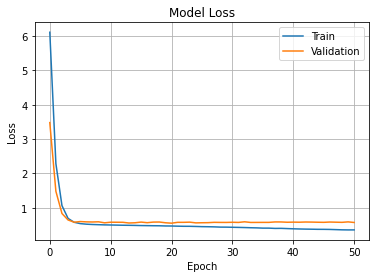

In [378]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

Accuracy & Evaluation

In [379]:
Y_train = Y_train[:8766-window_size]
Y_test = Y_test[:2922-window_size]

(8754, 12, 1)
(8754,)
(8754,)


<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'index in train set')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Train set')

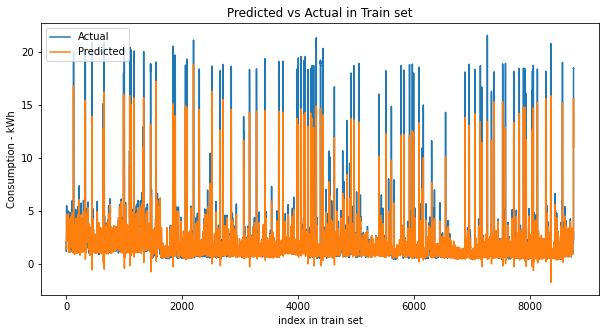

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'index in train set')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Train set')

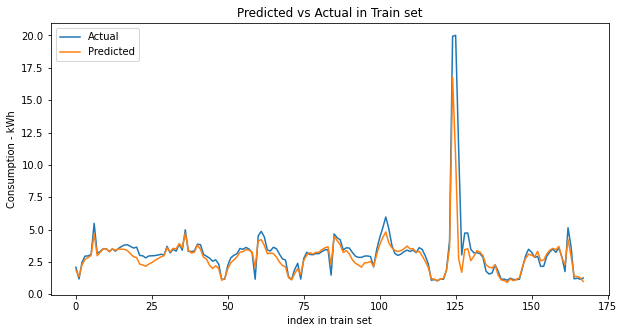

In [380]:
# train set performance
Y_train_pred_scaled = model.predict(X_train_scaled)
print(np.shape(Y_train_pred_scaled))

Y_train_pred_scaled= Y_train_pred_scaled[:,1,0]
print(np.shape(Y_train_pred_scaled))

Y_train_pred = scalerY.inverse_transform(Y_train_pred_scaled)

print(np.shape(Y_train_pred))

# visualize predicted vs actual in train set
plt.figure(figsize=(10,5))
plt.plot(Y_train, label='Actual')
plt.plot(Y_train_pred, label='Predicted')
plt.xlabel('index in train set')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Train set')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(Y_train.head(168), label='Actual')
plt.plot(Y_train_pred[:168], label='Predicted')
plt.xlabel('index in train set')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Train set')
plt.legend(loc='upper left')
plt.show()

(2910, 12, 1)
(2910,)


<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'index in test set')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Test set')

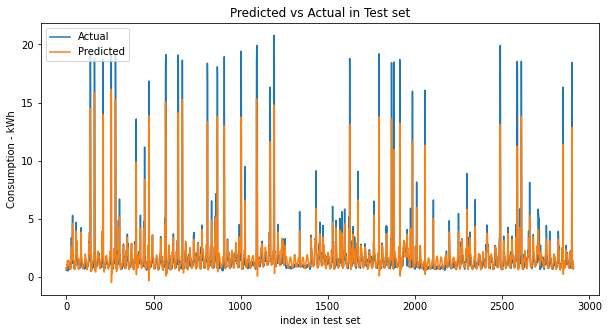

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'index in test set')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Test set')

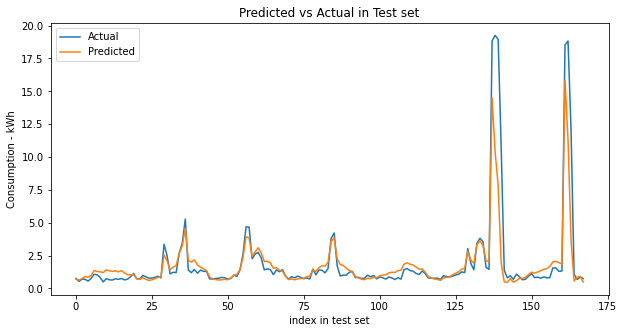

In [381]:
# train set performance
Y_test_pred_scaled = model.predict(X_test_scaled)
print(np.shape(Y_test_pred_scaled))

Y_test_pred_scaled= Y_test_pred_scaled[:,1,0]

Y_test_pred = scalerY.inverse_transform(Y_test_pred_scaled)

print(np.shape(Y_test_pred))

Y_test = pd.DataFrame.reset_index(Y_test, drop=True)

# visualize predicted vs actual in train set
plt.figure(figsize=(10,5))
plt.plot(Y_test, label='Actual')
plt.plot(Y_test_pred, label='Predicted')
plt.xlabel('index in test set')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Test set')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(Y_test.head(168), label='Actual')
plt.plot(Y_test_pred[:168], label='Predicted')
plt.xlabel('index in test set')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Test set')
plt.legend(loc='upper left')
plt.show()

In [382]:
mape = tf.keras.losses.MeanAbsolutePercentageError()

In [383]:
# Error Metric summary
model_performance = pd.DataFrame(columns=['Train MAE', 'Train RMSE', 'Train MAPE', 'Test MAE', 'Test RMSE', 'Test MAPE'])

Train_MAE = mean_absolute_error(Y_train, Y_train_pred)
Train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
Train_MAPE = mape(Y_train, Y_train_pred).numpy()

Test_MAE = mean_absolute_error(Y_test, Y_test_pred)
Test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
Test_MAPE = mape(Y_test, Y_test_pred).numpy()

model_performance = model_performance.append({
                        'Train MAE': Train_MAE,
                        'Train RMSE': Train_RMSE,
                        'Train MAPE': Train_MAPE,
                        'Test MAE': Test_MAE,
                        'Test RMSE': Test_RMSE,
                        'Test MAPE': Test_MAPE,},
                        ignore_index=True)

model_performance.round(2)

,Train MAE,Train RMSE,Train MAPE,Test MAE,Test RMSE,Test MAPE
0,0.45,1.14,97.22,0.49,1.25,80.04
